### Notebook to calculate Pearson coefficient from real data using both time and temperature amplitude ratio, to see whether 1D hypothesis is actually relevant or not.

In [1]:
#We get the data for point 46 (representing the highest k value, ie the most advective case)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from pyheatmy import *
from pyheatmy.time_series_multiperiodic import *
import os as os
import csv as csv 

#function to read the data
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

#Function to convert the dates

def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               "%d-%m-%Y %H:%M",  "%m-%d-%Y %H:%M",

               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")


In [5]:
#path 
root_path = os.getcwd()
file_path = os.path.join(root_path, '..', '..', 'dataAnalysis', 'data_traite', 'point52_temperature_traité.csv')
#Définition d'un dictionnaire pour les données 

dico = {}
dico['chemin temperature'] = file_path


temperature = read_csv(dico['chemin temperature'])

temperature['Temp_profondeur_10'] = temperature['Temp_profondeur_10'] + ZERO_CELSIUS
temperature['Temp_profondeur_20'] = temperature['Temp_profondeur_20'] + ZERO_CELSIUS
temperature['Temp_profondeur_30'] = temperature['Temp_profondeur_30'] + ZERO_CELSIUS
temperature['Temp_profondeur_40'] = temperature['Temp_profondeur_40'] + ZERO_CELSIUS

#Conversion des dates en datetime   

convertDates(temperature)

dico['temperature'] = temperature

#Affichage des données

dico['temperature'].columns = ['dates', 'T_10', 'T_20', 'T_30', 'T_40']

#Création des colonnes de date et de données pour initialiser l'objet time_series_multiperiodic

dates = dico['temperature']['dates'].to_numpy()

# Define the date format
date_format = "%Y-%m-%dT%H:%M:%S.%f"

# Convert each date string to a datetime object
# dates = [datetime.strptime(date, date_format) for date in dates]

data_temperature = dico['temperature'][['T_10', 'T_20', 'T_30', 'T_40']].to_numpy()

print(dates[:5], data_temperature[:5])


['2023-10-15T11:15:00.000000000' '2023-10-15T11:30:00.000000000'
 '2023-10-15T11:45:00.000000000' '2023-10-15T12:00:00.000000000'
 '2023-10-15T12:15:00.000000000'] [[285.401 286.252 286.767 287.168]
 [285.401 286.244 286.751 287.155]
 [285.413 286.237 286.736 287.14 ]
 [285.402 286.229 286.721 287.126]
 [285.395 286.222 286.707 287.113]]


To use methods from 'profile_temperature' to the end of the code, you should define 3 arguments :
time_series_dict_user1, 
 layers_list, 
 and col_dict.
To check how to define those, go to :
MOLONARI1D/pyheatmy/research/Temp_ampl_ratio_diffusive_case.ipynb
It will show you how to use this class, in general


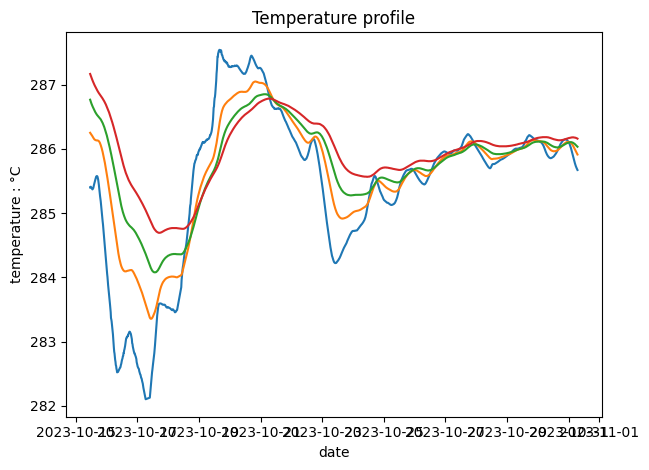

dt must be in seconds
dt must be in seconds


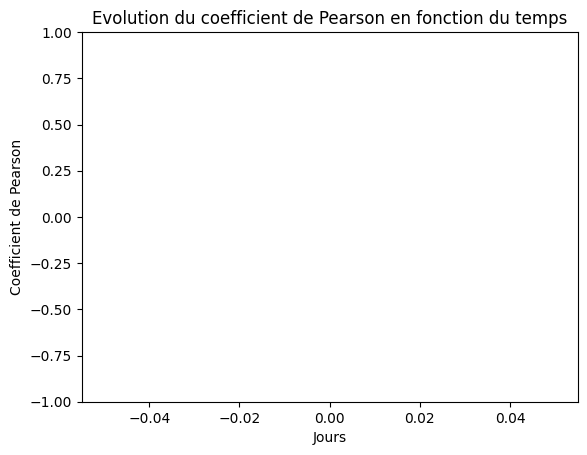

In [6]:
#Création de l'objet time_series_multiperiodic

dt = 15*NSECINMIN
depth_sensor = DEFAULT_sensor_depth

ts = time_series_multiperiodic('ts')

ts.values_time_series(dates, data_temperature, depth_sensors=depth_sensor)
ts.plot_temp()
ts.plot_pearson_coef()

# from 113
def plot_data(point_number, verbose = True):
    url = 'dataAnalysis\data_traite\point' + str(point_number) + '_temperature_traité.csv'
    df = pd.read_csv(url)
    df.columns = ['Date_heure', 'T_Sensor0', 'T_Sensor1', 'T_Sensor2', 'T_Sensor3']
    df['Date_heure'] = pd.to_datetime(df['Date_heure'], dayfirst = True)

    # Tracer toutes les colonnes sauf 'Date_heure' en fonction de 'Date_heure'
    df.set_index('Date_heure').plot(figsize=(10, 6), grid=True, title="Graphique des valeurs en fonction des dates")
    plt.xlabel("Date")
    plt.ylabel("Température (°C)")
    plt.title("signal de température pour le capteur " + str(point_number))
    plt.show()
